### **MLP CIFAR10**

Try to apply all the optimization resources learned and see if you can raise the accuracy. <br>
Try to get over 55% (but don't expect to go much over it) <br>
In the next class we will apply a convolutional network to this program and we will understand why CNN are better with images

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import os
import tensorflow as tf

# Disable all GPUs
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
from tensorflow.keras import models
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import ReLU, Dense, Softmax, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1, L2, L1L2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import ParameterGrid
from scikeras.wrappers import KerasClassifier

import sys
sys.stderr = open('err.txt', 'w')

I0000 00:00:1739458625.317261   47542 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:22:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1739458625.345479   47542 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:22:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1739458625.345523   47542 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:22:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1739458625.350007   47542 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:22:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1739458625.350185   47542 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:22:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

#### **Are we using GPU ?**

In [2]:
# DELETE THIS CELL IF YOU DON'T HAVE A GPU
# Activate GPU
from tensorflow.python.client import device_lib
from tensorflow.config import list_physical_devices
print('Num GPUs Available: ',len(list_physical_devices('GPU')))
devices = device_lib.list_local_devices()
gpu_devices = [device for device in devices if device.device_type == 'GPU']
for gpu in gpu_devices:
    print('Using', gpu.physical_device_desc)

Num GPUs Available:  1
Using device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:22:00.0, compute capability: 8.6


#### **Reading the Dataset**

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
type(x_train)                # data loaded in numpy arrays
print(x_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000, 1)


In [5]:
label_dict = {0: "airplane",
                     1: "automobile",
                     2: "bird",
                     3: "cat",
                     4: "deer",
                     5: "dog",
                     6: "frog",
                     7: "horse",
                     8: "ship",
                     9: "truck"}

#### **Print 10 random images as an example**

<Figure size 3200x3200 with 0 Axes>

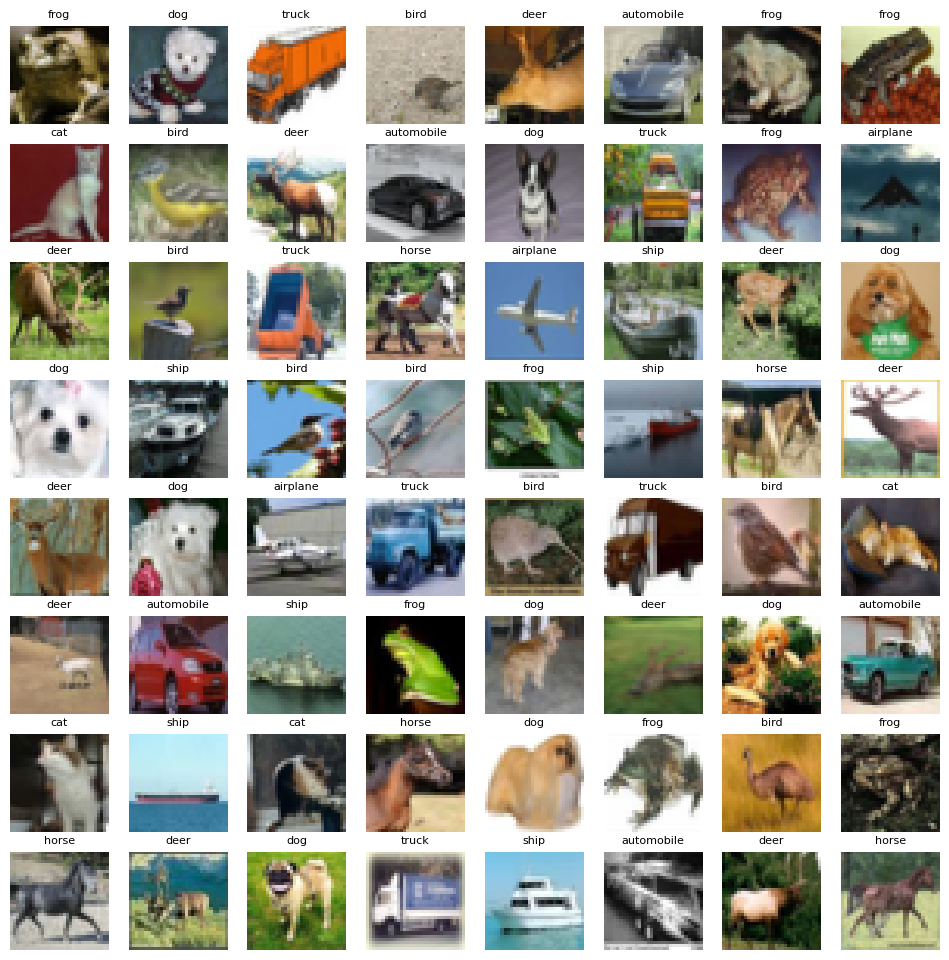

In [6]:
nrows = 4
ncols = 4
total_images = x_train.shape[0]

random_indices = np.random.choice(total_images, 64, replace = False)
random_images = x_train[random_indices]
random_labels = y_train[random_indices].ravel()
descriptive_labels = [label_dict[i] for i in random_labels]

fig = plt.gcf()
fig.set_size_inches(ncols * 8, nrows * 8)

fig, axes = plt.subplots(8,8, figsize=(12,12))

for i, ax in enumerate(axes.flat):  
    ax.imshow(random_images[i])  
    ax.axis('off')  
    ax.set_title(descriptive_labels[i], fontsize=8)

plt.savefig('cifar.png')
plt.show()

#### **Hyperparameters**

In [7]:
LEARNING_RATE = 0.001
batch_size = 128
num_epochs = 1  # Recommended num_epochs = 50
dropout_rate = 0.2


In [8]:
# reshape images to RGB scale with width & height are size 32
X_train = x_train.reshape(50000, 32 * 32 * 3)
X_test = x_test.reshape(10000, 32 * 32 * 3)

# normalization to avoid gradient explode or vanish
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255.0
X_test /= 255.0

# convert class into one hot encoder
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)
print(X_test.shape)
input_shape = X_test.shape[1]
print(input_shape, y_test.shape)

(10000, 3072)
3072 (10000, 10)


#### **Create ANN**

In [9]:
"""
Fill the network with your code. Some recommendations. 
Use several layers (3-4)
Pyramid structure (every layer smaller)
Use ADAM, but try RMSPROP as well
Play with the learning rate. The one you have in the code is too small
Use the early stopping callback. See the code if you don't understand how I'll tell you in the forum 
"""


def build_MLP():
    inputs = Input(shape=(input_shape,))
    x = Dense(32)(inputs)
#    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.0)(x)
    x = Dense(10)(x)
    output = Softmax()(x)
    
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    return model

In [10]:
# Configure early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Log when training is stopped
    mode='min',          # Stop training when the monitored quantity has stopped decreasing
    restore_best_weights = True  # Restore model weights from the epoch with the best value of the monitored quantity
)

adam = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
SGD  = SGD(learning_rate=LEARNING_RATE)

In [11]:
MLP = build_MLP()
MLP.compile(loss='categorical_crossentropy', optimizer=SGD, metrics=['accuracy'])
history = MLP.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_test, y_test),
                 callbacks=[early_stopping])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        98,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,666 (385.41 KB)

 Trainable params: 98,666 (385.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.0992 - loss: 2.3164 - val_accuracy: 0.1002 - val_loss: 2.3030
Epoch 2/300
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0987 - loss: 2.3035 - val_accuracy: 0.0998 - val_loss: 2.3038
Epoch 3/300
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1404 - loss: 2.2176 - val_accuracy: 0.1725 - val_loss: 2.3267
Epoch 4/300
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.1673 - loss: 2.1363 - val_accuracy: 0.1814 - val_loss: 2.1279
Epoch 5/300
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1680 - loss: 2.1367 - val_accuracy: 0.1877 - val_loss: 2.0666
Epoch 6/300
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1674 - loss: 2.1362 - val_accuracy: 0.1672 - val_loss: 2.1536
Epoch 7/300
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1714 - loss: 2.1293 - val_accuracy: 0.1558 - val_loss: 2.1734
Epoch 8/300
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1682 - loss: 2

In [12]:
# Evaluate the model
test_loss, test_acc = MLP.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc * 100:.2f}%')

313/313 - 0s - 975us/step - accuracy: 0.2551 - loss: 1.9352
Test accuracy: 25.51%


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


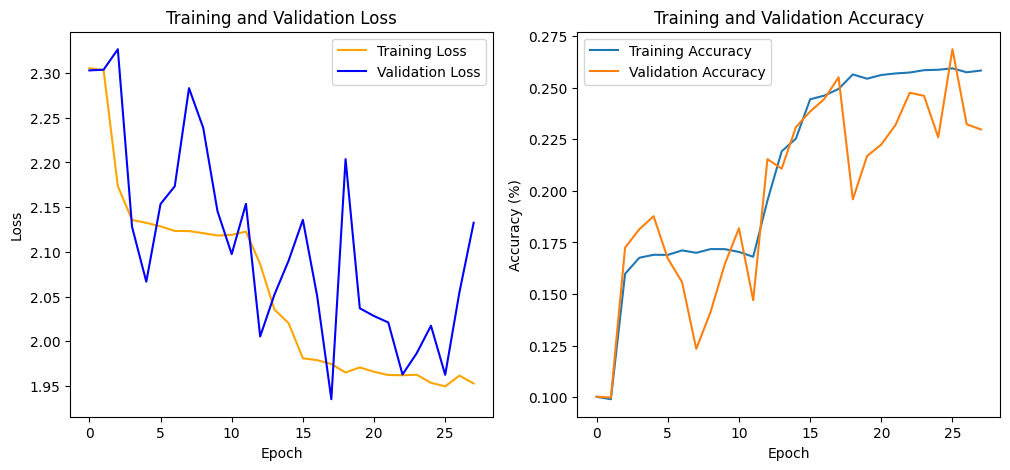

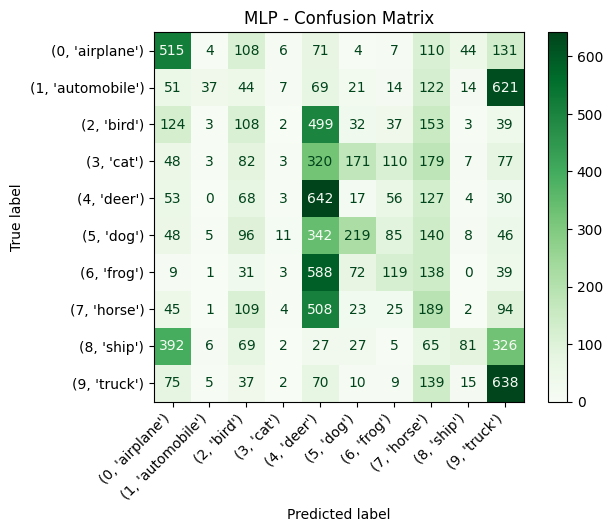

In [13]:
model = MLP
num_classes = 10
# Plot training loss, accuracy and confussion matrix
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

# Confusion Matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(label_dict.items()))
cmd.plot(cmap=plt.cm.Greens)
plt.title(f"MLP - Confusion Matrix")
plt.xticks(rotation=45, ha='right')  # ha is the horizontal alignment
plt.show()

In [14]:
import session_info
session_info.show(html=False)

-----
keras               3.6.0
matplotlib          3.9.2
numpy               1.26.4
scikeras            0.13.0
session_info        1.0.0
sklearn             1.5.2
tensorflow          2.17.1
-----
IPython             8.28.0
jupyter_client      8.6.3
jupyter_core        5.7.2
-----
Python 3.12.3 (main, Jan 17 2025, 18:03:48) [GCC 13.3.0]
Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2025-02-13 15:58


### **Assignment 2 Experiments**

In [ ]:
# Define a function to build the model with different configurations
def build_MLP(hidden_layers, activation, optimizer, learning_rate):
    inputs = Input(shape=(input_shape,))
    x = inputs
    for units in hidden_layers:
        x = Dense(units)(x)
        x = activation()(x)
        x = Dropout(dropout_rate)(x)
    x = Dense(10)(x)
    output = Softmax()(x)
    
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer(learning_rate=learning_rate), metrics=['accuracy'])
    return model

# Create a function to run the experiments
def run_experiment(exp, activation, optimizer, loss, hidden_layers, learning_rate, epochs):
    print(f"Running Experiment {exp}")
    model = build_MLP(hidden_layers, activation, optimizer, learning_rate)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping])
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print(f"Experiment {exp} - Test accuracy: {test_acc * 100:.2f}%")
    
    # Plot training loss, accuracy and confusion matrix
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='orange')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss - {exp}')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Training and Validation Accuracy - {exp}')
    plt.legend()

    # Confusion Matrix
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    cmd = ConfusionMatrixDisplay(cm, display_labels=list(label_dict.values()))
    cmd.plot(cmap=plt.cm.Greens)
    plt.title(f"Confusion Matrix - {exp}")
    plt.xticks(rotation=45, ha='right')  # ha is the horizontal alignment
    plt.show()
    
    return history, test_acc

# Run the experiments with the specified configurations
experiments = [
    {"exp": "E6", "activation": ReLU, "optimizer": Adam, "loss": 'categorical_crossentropy', "hidden_layers": [128, 128, 128], "learning_rate": 0.001, "epochs": 75},
    {"exp": "E7", "activation": Tanh, "optimizer": Adam, "loss": 'categorical_crossentropy', "hidden_layers": [256, 256, 256, 256], "learning_rate": 0.0005, "epochs": 50},
    {"exp": "E8", "activation": LeakyReLU, "optimizer": SGD, "loss": 'categorical_crossentropy', "hidden_layers": [64, 64], "learning_rate": 0.01, "epochs": 100},
    {"exp": "E9", "activation": ReLU, "optimizer": RMSprop, "loss": 'categorical_crossentropy', "hidden_layers": [64, 64, 64], "learning_rate": 0.0001, "epochs": 150},
    {"exp": "E10", "activation": Tanh, "optimizer": Adam, "loss": 'categorical_crossentropy', "hidden_layers": [128, 128, 128, 128], "learning_rate": 0.001, "epochs": 200},
]

results = []
for exp in experiments:
    history, test_acc = run_experiment(**exp)
    results.append((exp["exp"], test_acc))

# Print the results
for exp, acc in results:
    print(f"Experiment {exp} - Test accuracy: {acc * 100:.2f}%")